# Cross-resonance gate between a transmon and a fluxonium: driving fluxonium

In this notebook we study the cross-resonance two-qubit gate between a transmon and a fluxonium. 

In [1]:
import time
from collections import defaultdict
from itertools import product, combinations
from typing import List, Dict, Callable, Optional
import pathlib
import copy
import json
import math
import cmath

import numpy as np
import xarray as xr
import scipy.integrate
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from pysqkit import qubits, systems, couplers, drives, solvers, util
from util_tf_cr import single_qubit_corrections, energy_levels_diagram

import pysqkit.util.transformations as trf
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit.util.linalg import get_mat_elem
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.tomography import TomoEnv

from pysqkit.solvers.solvkit import integrate
from pysqkit.solvers import solvkit

from IPython.display import display, Latex

In [2]:
SOLVER_OPTIONS = qtp.solver.Options()
SOLVER_OPTIONS.atol = 1e-12
SOLVER_OPTIONS.rtol = 1e-10

In [3]:
TEX_RC_PARAMS = {
    'backend': 'ps',
    'text.latex.preamble': [r'\usepackage{gensymb}'],
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'font.family': 'serif'
}

# Define auxillary functions used

In [4]:
def comp_state_labels(num_qubits: Optional[int] = 2):
    state_combinations = product("01", repeat=num_qubits)
    labels = ["".join(states) for states in state_combinations]
    return labels

def state_labels(*qubit_states):
    state_combinations = product(*qubit_states)
    labels = ["".join(states) for states in state_combinations]
    return labels

def get_states(system, state_labels):
    states = {}
    for label in state_labels:
        _state = system.state(label)[1]
        
        loc = np.argmax(np.abs(_state))
        phase = cmath.phase(_state[loc])
        
        states[label] = np.exp(-1j*phase) * _state
    return states

In [5]:
def extract_freqs(
    qubit: systems.Qubit, 
) -> Dict[str, float]:
    """
    Description
    --------------------------------------------------------------
    Returns the transition frequencies of a given qubit.
    """
    
    num_levels = qubit.dim_hilbert
    
    results = {}
    
    states = [qubit.state(str(level)) for level in range(num_levels)]
        
    for level_i, level_j in combinations(range(num_levels), 2):
        freq_i = states[level_i][0]
        freq_j = states[level_j][0]
        results[f"freq_{level_i}{level_j}"] = freq_j - freq_i

    return results

In [6]:
def zz_crosstalk(system: systems.QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def xz_coeff(comp_states, op) -> float:
    xz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    xz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(xz0 - xz1))/2

def xi_coeff(comp_states, op) -> float:
    xi0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    xi1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(xi0 + xi1))/2

In [7]:
def func_to_minimize(
    x: List[float],
    rise_time: float,
    amp: float
) -> float:
    pulse_time = x[0]
    time_step = 1e-3
    num_points = int(pulse_time/time_step)
    times = np.linspace(0, pulse_time, num_points)
    
    pulse = gaussian_top(times, rise_time, pulse_time)
    integral = scipy.integrate.simpson(2*np.pi*amp*pulse, times)
    return np.abs(integral - np.pi/4)  #Watch out factor of 2?  

In [8]:
def minimize_drive_time(
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    eps_drive : float,
    rise_time : Optional[float] = 5.0,
    *,
    init_time : Optional[float] = 100.0,
) -> float:
    
    q_op = system["control"].charge_op()
    args_to_pass = (rise_time, np.abs(xz_coeff(comp_states, q_op))*0.5*eps_drive)

    try:
        minimization_result = minimize(
            func_to_minimize, 
            init_time,
            args=args_to_pass
        )
        gate_time = minimization_result['x'][0]
    except ValueError:
        gate_time = None
    
    return gate_time

def get_drive_params(
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    eps_drive : float,
    rise_time : Optional[float] = 10.0,
    *,
    init_time : Optional[float] = 20.0,
    detuning : Optional[float] = 0,
    points_per_period : Optional[int] = 10
):
    pulse_time = minimize_drive_time(
        system = coupled_sys,
        comp_states = comp_states,
        eps_drive = eps_drive,
        rise_time = rise_time,
        init_time=init_time
    )
    
    if pulse_time is None:
        raise ValueError("Pulse time minimization has failed.") # Should be handled differently
    
    drive_freq = system["target"].freq
    
    num_points = int(pulse_time * drive_freq * points_per_period)
    times = np.linspace(0, pulse_time, num_points)

    params = dict(
        phase = 0, 
        time = times, 
        rise_time = rise_time, 
        pulse_time = pulse_time,
        amp = eps_drive, 
        freq = drive_freq + detuning
    )
    return params

In [9]:
def run_simulation(
    times: np.ndarray,
    system: systems.QubitSystem, 
    init_state: qtp.qobj.Qobj, 
    options: Optional[qtp.solver.Options] = None,
    *,
    solver="mesolve",
    with_noise: Optional[bool] = False
) -> qtp.solver.Result:
    sys_hamil = system.hamiltonian(as_qobj=True)
    drive_hamils = []
    drive_pulses = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                drive_hamils.append(drive.hamiltonian(as_qobj=True))
                drive_pulses.append(drive.eval_pulse())
    
    if with_noise:
        jump_ops = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
    else:
        jump_ops = []
                    
    result = integrate(
        times, 
        init_state, 
        sys_hamil, 
        drive_hamils,
        drive_pulses, 
        jump_ops, 
        solver=solver, 
        options=options
    )
                    
    return result  

In [10]:
def get_probabilities(
    state_labels : List[str], 
    system : systems.QubitSystem, 
    output_states : List[qtp.Qobj],
) -> Dict:
    probs_dict = {}
    
    for label in state_labels:
        probs = []
        
        state = system.state(label, as_qobj=True)[1]        
        projector = state*state.dag()
        
        for out_state in output_states:
            prob = qtp.expect(projector, out_state)
            probs.append(prob)
        
        probs_dict[label] = probs
    return probs_dict

In [11]:
def get_leakage(
    times: np.ndarray,
    system: systems.QubitSystem,
    comp_states: List[np.ndarray],
    options: Optional[qtp.solver.Options] = None,
    *,
    with_noise: Optional[bool] = False
):
    env_syst = TomoEnv(
        system=system, 
        time=2*np.pi*times, 
        options=options, 
        with_noise=with_noise
    )
    
    leakage = env_syst.leakage(comp_states)
    return leakage    

In [12]:
def get_fig_size(fig_width = None, fig_height = None, columns = 1):
    MAX_HEIGHT = 8.0

    if columns not in [1, 2]:
        raise ValueError("Plotting in three-column style is not supported")
    golden_mean = (np.sqrt(5) - 1.0)/2.0

    fig_width = fig_width or 3.39 if columns == 1 else 6.9  # width in inches

    fig_height = fig_height or fig_width*golden_mean  # height in inches

    if fig_height > MAX_HEIGHT:
        warn("Figure height {} is too large, setting to {}"
                      "inches instead".format(fig_height, MAX_HEIGHT))
        fig_height = MAX_HEIGHT
        
    fig_size = (fig_width, fig_height)
    return fig_size

# Set up directories for data and image saving

In [13]:
NOTEBOOK_DIR = pathlib.Path.cwd()

DATA_FOLDER = NOTEBOOK_DIR / "data"
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

IMG_FOLDER = NOTEBOOK_DIR / "img"
IMG_FOLDER.mkdir(parents=True, exist_ok=True)

# Introducing the qubits and the coupled system

In [16]:
with open(NOTEBOOK_DIR.parent / "flx_transm_params.txt") as param_file:
    PARAM_SETS = json.load(param_file)
    
set_ind = "CR_3"
PARAM_SET = PARAM_SETS[set_ind]

In [18]:
TEMPERATURE = 0.020
THERMAL_ENERGY = util.phys.temperature_to_thermalenergy(TEMPERATURE)

TRANSMON_LEVELS = 3
FLUXONIUM_LEVELS = 6

TRANSMON_ANHARM = PARAM_SET["anharm_t"]
DIEL_LOSS_TANGENT = 3.6e-6

TARGET_FREQ = PARAM_SET["max_freq_t"]
SPEC_FREQ = 4.3

#Target transmon
target_transmon = qubits.SimpleTransmon(
    label = 'target', 
    max_freq = TARGET_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

#Control fluxonium
control_fluxonium = qubits.Fluxonium(
    label = 'control', 
    charge_energy = PARAM_SET["charge_energy_f"], 
    induct_energy = PARAM_SET["induct_energy_f"], 
    joseph_energy = PARAM_SET["joseph_energy_f"], 
    diel_loss_tan = PARAM_SET["diel_loss_tan_f"],
    env_thermal_energy = THERMAL_ENERGY,
)
control_fluxonium.diagonalize_basis(FLUXONIUM_LEVELS)

# Spectator transmon
spec_transmon = qubits.SimpleTransmon(
    label = 'spectator', 
    max_freq = SPEC_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

In [19]:
# We also add a drive on the fluxonium
control_fluxonium.add_drive(
    drives.microwave_drive,
    label = 'cr_drive',
    pulse = drives.pulses.cos_modulation,
    pulse_shape = drives.pulse_shapes.gaussian_top
)

In [20]:
coup_strength = PARAM_SET["jc"]

control_spectator_coup = couplers.capacitive_coupling(
    qubits=[control_fluxonium, spec_transmon],
    strength=coup_strength,
)

target_control_coup = couplers.capacitive_coupling(
    qubits=[target_transmon, control_fluxonium],
    strength=coup_strength,
)

In [21]:
bare_sys = target_transmon.couple_to(
    control_fluxonium,
)

coupled_sys = target_transmon.couple_to(
    control_fluxonium, 
    coupling = couplers.capacitive_coupling, 
    strength=coup_strength,
)

full_sys = systems.QubitSystem(
    qubits=[target_transmon, control_fluxonium, spec_transmon],
    coupling=[target_control_coup, control_spectator_coup]
)

In [23]:
fluxonium_freqs = extract_freqs(control_fluxonium)

In [24]:
for label, freq in fluxonium_freqs.items():
    print(f"{label} : {freq} (GHz)")

freq_01 : 0.5818489963974245 (GHz)
freq_02 : 3.970435554849514 (GHz)
freq_03 : 6.574488472163292 (GHz)
freq_04 : 9.86447323618929 (GHz)
freq_05 : 13.229087316443394 (GHz)
freq_12 : 3.3885865584520896 (GHz)
freq_13 : 5.992639475765868 (GHz)
freq_14 : 9.282624239791867 (GHz)
freq_15 : 12.64723832004597 (GHz)
freq_23 : 2.604052917313778 (GHz)
freq_24 : 5.894037681339777 (GHz)
freq_25 : 9.25865176159388 (GHz)
freq_34 : 3.2899847640259985 (GHz)
freq_35 : 6.654598844280102 (GHz)
freq_45 : 3.3646140802541034 (GHz)


In [239]:
0.5*fluxonium_freqs["freq_15"] - (fluxonium_freqs["freq_03"] + TRANSMON_ANHARM)

0.04913068785969266

In [25]:
#EPS_DRIVE = 0.1 #GHz
EPS_DRIVE = 0.3 #GHz
#EPS_DRIVE = 0.5 #GHz
RISE_TIME = 10

comp_labels = comp_state_labels(2)
comp_states = get_states(coupled_sys, comp_labels)

drive_params = get_drive_params(
    system = coupled_sys,
    comp_states = comp_states,
    eps_drive = EPS_DRIVE,
    rise_time = RISE_TIME,
)
times =  drive_params["time"]
coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)

# Scans around ZZ condition

In [22]:
SAVE_DATA = True
FREQ_RANGE = 0.15 #GHz
NUM_POINTS = 41

collision_cond = fluxonium_freqs["freq_12"]
target_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(2)

for tar_freq in target_freqs:
    target_tmon = qubits.SimpleTransmon(
        label = 'target', 
        max_freq = tar_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    coupled_sys = target_tmon.couple_to(
        control_fluxonium, 
        coupling = couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    results.append(zz_crosstalk(coupled_sys))
    
zz_crosstalks = xr.DataArray(
    results,
    dims = ["target_freq"],
    coords = dict(target_freq = target_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        points_per_drive_period = 10,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    collision_type = "zz_crosstalk"
    trans = "ctrl_12"    
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_transition_low_drive_scan.nc"
    zz_crosstalks.to_netcdf(DATA_FOLDER / da_name)

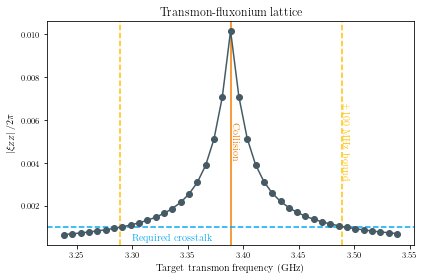

In [23]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.1
min_crosstalk = 1e-3

if LOAD_DATA:
    lattice_type = "mixed"
    collision_type = "zz_crosstalk"
    trans = "ctrl_12"    
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_transition_low_drive_scan.nc"
    
    zz_crosstalks = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=100)

    ax.axvline(
        zz_crosstalks.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        zz_crosstalks.collision_cond, 
        5e-3, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_crosstalk, linestyle = "--", color="#03a9f4")
    ax.text(
        3.3, 
        min_crosstalk - 5e-4, 
        "Required crosstalk", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(zz_crosstalks.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(zz_crosstalks.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        zz_crosstalks.collision_cond + freq_range, 
        5e-3, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(zz_crosstalks.target_freq, np.abs(zz_crosstalks), linestyle="-", marker="o", color="#455a64")
    ax.set_ylabel(r"$\left|\xi_{ZZ}\right| / 2\pi$")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "zz_crosstalk"
        trans = "ctrl_12"    
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_transition_low_drive_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

In [24]:
SAVE_DATA = True
FREQ_RANGE = 0.15 #GHz
NUM_POINTS = 41

collision_cond = fluxonium_freqs["freq_03"]
target_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(2)

for tar_freq in target_freqs:
    target_tmon = qubits.SimpleTransmon(
        label = 'target', 
        max_freq = tar_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    coupled_sys = target_tmon.couple_to(
        control_fluxonium, 
        coupling = couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    results.append(zz_crosstalk(coupled_sys))
    
zz_crosstalks = xr.DataArray(
    results,
    dims = ["target_freq"],
    coords = dict(target_freq = target_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        points_per_drive_period = 10,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    collision_type = "zz_crosstalk"
    trans = "ctrl_03"    
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_transition_low_drive_scan.nc"
    zz_crosstalks.to_netcdf(DATA_FOLDER / da_name)

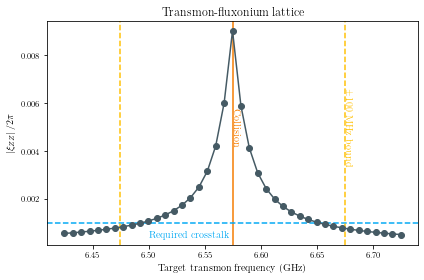

In [25]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.1
min_crosstalk = 1e-3

if LOAD_DATA:
    lattice_type = "mixed"
    collision_type = "zz_crosstalk"
    trans = "ctrl_03"    
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_transition_low_drive_scan.nc"
    
    zz_crosstalks = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=100)

    ax.axvline(
        zz_crosstalks.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        zz_crosstalks.collision_cond, 
        5e-3, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_crosstalk, linestyle = "--", color="#03a9f4")
    ax.text(
        6.5, 
        min_crosstalk - 5e-4, 
        "Required crosstalk", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(zz_crosstalks.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(zz_crosstalks.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        zz_crosstalks.collision_cond + freq_range, 
        5e-3, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(zz_crosstalks.target_freq, np.abs(zz_crosstalks), linestyle="-", marker="o", color="#455a64")
    ax.set_ylabel(r"$\left|\xi_{ZZ}\right| / 2\pi$")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "zz_crosstalk"
        trans = "ctrl_03"    
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_transition_low_drive_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

# Scans around the CR condition

### Scan around the $f_{control}^{0 \rightarrow 4} = 2f_{target}^{0 \rightarrow 1}$ frequency collision

In [26]:
SAVE_DATA = True
FREQ_RANGE = 0.15 #GHz
NUM_POINTS = 41

collision_cond = 0.5*fluxonium_freqs["freq_04"]
target_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(2)

for tar_freq in target_freqs:
    target_tmon = qubits.SimpleTransmon(
        label = 'target', 
        max_freq = tar_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    coupled_sys = target_tmon.couple_to(
        control_fluxonium, 
        coupling = couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    comp_states = get_states(coupled_sys, comp_labels)
    
    drive_params = get_drive_params(
        system = coupled_sys,
        comp_states = comp_states,
        eps_drive = EPS_DRIVE,
        rise_time = RISE_TIME,
    )
    times =  drive_params["time"]
    coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = coupled_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )

    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["target_freq"],
    coords = dict(target_freq = target_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        points_per_drive_period = 10,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    collision_type = "cross_res"
    n_photons = 2
    trans = "ctrl_04"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

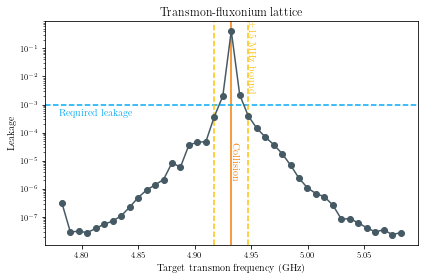

In [196]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.015
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "mixed"
    collision_type = "cross_res"
    n_photons = 2
    trans = "ctrl_04"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=100)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-5, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        4.78, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range, 
        5e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.target_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "cross_res"
        n_photons = 2
        trans = "ctrl_04"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

### Scan around the $f_{control}^{0 \rightarrow 5} = 3f_{target}^{0 \rightarrow 1}$ frequency collision

In [28]:
SAVE_DATA = True
FREQ_RANGE = 0.1 #GHz
NUM_POINTS = 41

collision_cond = fluxonium_freqs["freq_05"]/3
target_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(2)

for tar_freq in target_freqs:
    target_tmon = qubits.SimpleTransmon(
        label = 'target', 
        max_freq = tar_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    coupled_sys = target_tmon.couple_to(
        control_fluxonium, 
        coupling = couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    comp_states = get_states(coupled_sys, comp_labels)
    
    drive_params = get_drive_params(
        system = coupled_sys,
        comp_states = comp_states,
        eps_drive = EPS_DRIVE,
        rise_time = RISE_TIME,
    )
    times =  drive_params["time"]
    coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = coupled_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )

    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["target_freq"],
    coords = dict(target_freq = target_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        points_per_drive_period = 10,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    collision_type = "cross_res"
    n_photons = 3
    trans = "ctrl_05"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

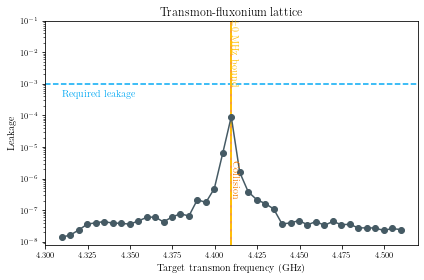

In [191]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.00
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "mixed"
    collision_type = "cross_res"
    n_photons = 3
    trans = "ctrl_05"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=200)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-6, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        4.31, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range, 
        1e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.target_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")
    ax.set_ylim(top=1e-1)
    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "cross_res"
        n_photons = 3
        trans = "ctrl_05"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

### Scan around the $f_{control}^{1 \rightarrow 5} = 2f_{target}^{0 \rightarrow 1}$ frequency collision

In [30]:
SAVE_DATA = True
FREQ_RANGE = 0.1 #GHz
NUM_POINTS = 41

collision_cond = fluxonium_freqs["freq_15"]/2
target_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(2)

for tar_freq in target_freqs:
    target_tmon = qubits.SimpleTransmon(
        label = 'target', 
        max_freq = tar_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    coupled_sys = target_tmon.couple_to(
        control_fluxonium, 
        coupling = couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    comp_states = get_states(coupled_sys, comp_labels)
    
    drive_params = get_drive_params(
        system = coupled_sys,
        comp_states = comp_states,
        eps_drive = EPS_DRIVE,
        rise_time = RISE_TIME,
    )
    times =  drive_params["time"]
    coupled_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = coupled_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )

    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["target_freq"],
    coords = dict(target_freq = target_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        points_per_drive_period = 10,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    collision_type = "cross_res"
    n_photons = 2
    trans = "ctrl_15"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

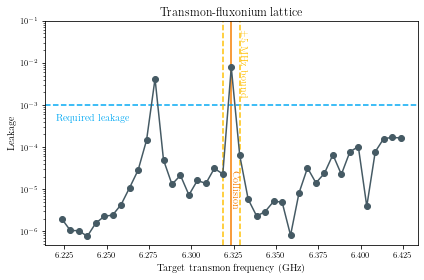

In [187]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.005
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "mixed"
    collision_type = "cross_res"
    n_photons = 2
    trans = "ctrl_15"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=200)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-5, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        6.22, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range, 
        1e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.target_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")
    ax.set_ylim(top=1e-1)
    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "cross_res"
        n_photons = 2
        trans = "ctrl_15"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

# Showcasing second peak, visible only for low drive strengths (eps = 0.1)

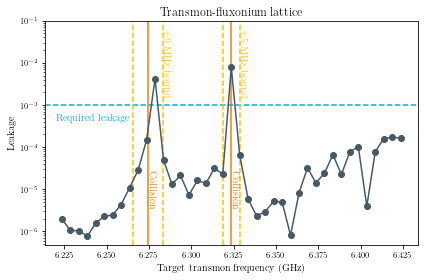

In [223]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range_1 = 0.005
freq_range_2 = 0.009
min_leakage_rate = 1e-3

other_collision_cond = fluxonium_freqs["freq_03"] + TRANSMON_ANHARM

if LOAD_DATA:
    lattice_type = "mixed"
    collision_type = "cross_res"
    n_photons = 2
    trans = "ctrl_15"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=200)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.axvline(
        other_collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-5, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )
    ax.text(
        other_collision_cond, 
        1e-5, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        6.22, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range_1, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range_1, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range_1, 
        1e-2, 
        f"$\pm${int(freq_range_1*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )
    
    ax.axvline(other_collision_cond - freq_range_2, linestyle = "--", color="#ffc107")
    ax.axvline(other_collision_cond + freq_range_2, linestyle = "--", color="#ffc107")
    ax.text(
        other_collision_cond + freq_range_2, 
        1e-2, 
        f"$\pm${int(freq_range_2*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.target_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Target transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")
    ax.set_ylim(top=1e-1)
    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "cross_res"
        n_photons = 2
        trans = "ctrl_15"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_and_cross_res_col_10_23_2-photon_transition_low_drive_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

# Scans with the spectator transmon frequency

### Setting up the drive parameters between the control and target

In [171]:
target_transmon = qubits.SimpleTransmon(
    label = 'target', 
    max_freq = TARGET_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

coupled_sys = target_transmon.couple_to(
    control_fluxonium, 
    coupling = couplers.capacitive_coupling, 
    strength=coup_strength,
)

comp_labels = comp_state_labels(2)
comp_states = get_states(coupled_sys, comp_labels)

drive_params = get_drive_params(
    system = coupled_sys,
    comp_states = comp_states,
    eps_drive = EPS_DRIVE,
    rise_time = RISE_TIME,
)
times =  drive_params["time"]

### Scan around the $f_{spec}^{0 \rightarrow 1} + f_{target}^{0\rightarrow 1} = f_{control}^{0\rightarrow 4}$ frequency collision

In [172]:
SAVE_DATA = True
FREQ_RANGE = 0.1 #GHz
NUM_POINTS = 41

collision_cond = fluxonium_freqs["freq_04"] - target_transmon.freq
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(3)

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_fluxonium, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_fluxonium, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states = get_states(full_sys, comp_labels)
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    
    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        pulse_time = drive_params["pulse_time"],
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    collision_type = "spectator"
    n_photons = 2
    trans = "ctrl_04"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

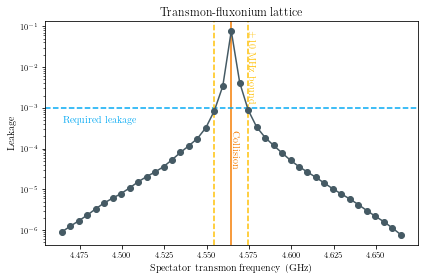

In [235]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.010
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "mixed"
    collision_type = "spectator"
    n_photons = 2
    trans = "ctrl_04"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=200)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-4, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        4.465, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range, 
        1e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.spectator_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Spectator transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "spectator"
        n_photons = 2
        trans = "ctrl_04"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

### Scan around the $f_{spec}^{1 \rightarrow 2} = f_{target}^{0\rightarrow1}$ frequency collision

In [174]:
SAVE_DATA = True
FREQ_RANGE = 0.1 #GHz
NUM_POINTS = 41

collision_cond = target_transmon.freq - TRANSMON_ANHARM
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(3)

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_fluxonium, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_fluxonium, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states = get_states(full_sys, comp_labels)
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    
    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        pulse_time = drive_params["pulse_time"],
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    collision_type = "spectator"
    n_photons = 1
    trans = "spec_12"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

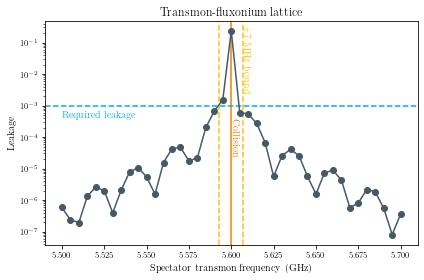

In [234]:
SAVE_IMAGE = True
LOAD_DATA = True

freq_range = 0.007
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "mixed"
    collision_type = "spectator"
    n_photons = 1
    trans = "spec_12"
    da_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_scan.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=200)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-4, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        5.5, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range, 
        3e-2, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.spectator_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Spectator transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "spectator"
        n_photons = 1
        trans = "spec_12"
        image_name = f"{lattice_type}_lat_{collision_type}_col_{trans}_{n_photons}-photon_transition_low_drive_bounds"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

# Extra analysis

In [113]:
#Target transmon
_tar_tmon = qubits.SimpleTransmon(
    label = 'target', 
    max_freq = 6.275, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

#Control fluxonium
_ctrl_flx = qubits.Fluxonium(
    label = 'control', 
    charge_energy = PARAM_SET["charge_energy_f"], 
    induct_energy = PARAM_SET["induct_energy_f"], 
    joseph_energy = PARAM_SET["joseph_energy_f"], 
    diel_loss_tan = PARAM_SET["diel_loss_tan_f"],
    env_thermal_energy = THERMAL_ENERGY,
)
_ctrl_flx.diagonalize_basis(FLUXONIUM_LEVELS)

# We also add a drive on the fluxonium
_ctrl_flx.add_drive(
    drives.microwave_drive,
    label = 'cr_drive',
    pulse = drives.pulses.cos_modulation,
    pulse_shape = drives.pulse_shapes.gaussian_top
)

_coup_sys = _tar_tmon.couple_to(
    _ctrl_flx, 
    coupling = couplers.capacitive_coupling, 
    strength=coup_strength,
)

In [114]:
from itertools import product

_eps_drive = 0.1 #GHz
_rise_time = 10
d_comp = 4

comp_labels = comp_state_labels(2)
comp_states = get_states(_coup_sys, comp_labels)


leak_labels = []

sys_levels = [range(q.dim_hilbert) for q in _coup_sys]
for q_levels in product(*sys_levels):
    label = "".join(map(str,q_levels))
    if label not in comp_labels:
        leak_labels.append(label)
        
comp_states_list = list(comp_states.values())
_proj_comp = np.einsum('ai, aj -> ij', comp_states_list, np.conj(comp_states_list))
subsys_dims = list(q.dim_hilbert for q in _coup_sys)
proj_comp = qtp.Qobj(inpt=_proj_comp, dims=[subsys_dims, subsys_dims], isherm=True)


drive_params = get_drive_params(
    system = _coup_sys,
    comp_states = comp_states,
    eps_drive = _eps_drive,
    rise_time = _rise_time,
)
times =  drive_params["time"]
_coup_sys['control'].drives['cr_drive'].set_params(**drive_params)

In [115]:
res = run_simulation(
    times = 2*np.pi*times,
    system=_coup_sys,
    init_state = proj_comp/d_comp, 
    options = SOLVER_OPTIONS

)

In [146]:
eval_step = 50

eval_times = times[::eval_step]

leak_probs = get_probabilities(
    state_labels = leak_labels, 
    system = _coup_sys, 
    output_states = res.states[::eval_step], 
)
comp_probs = get_probabilities(
    state_labels = comp_labels, 
    system = _coup_sys, 
    output_states = res.states[::eval_step], 
)

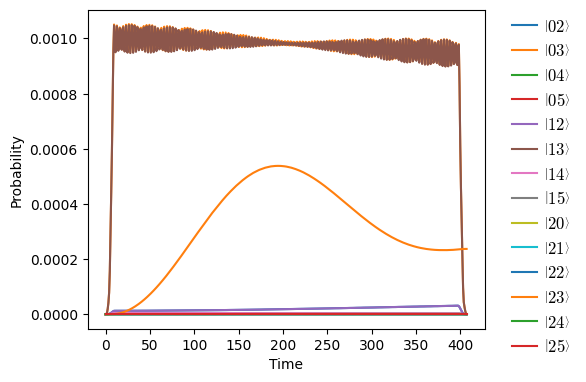

In [147]:
fig, ax = plt.subplots(dpi=100)

for ind, label in enumerate(leak_labels):
    ax.plot(
        eval_times, 
        eval_probs[label], 
        label=f'$\\left|{label}\\right\\rangle$'
    )
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=12
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

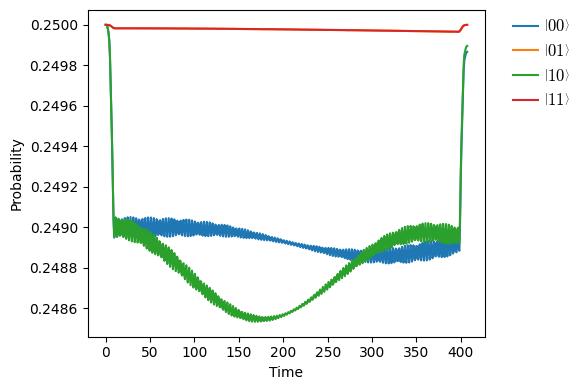

In [148]:
fig, ax = plt.subplots(dpi=100)

for ind, label in enumerate(comp_labels):
    ax.plot(
        eval_times, 
        comp_probs[label], 
        label=f'$\\left|{label}\\right\\rangle$'
    )
    
plt.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4,
    fontsize=12
)
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Probability")
plt.tight_layout()

In [149]:
for label in comp_labels:
    display(Latex(r'$P_{{leak, {}  }} = {:.7f}$'.format(label, comp_probs[label][-1])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [118]:
for label in leak_labels:
    display(Latex(r'$P_{{leak, {}  }} = {:.7f}$'.format(label, eval_probs[label][-1])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
target_transmon = qubits.SimpleTransmon(
    label = 'target', 
    max_freq = TARGET_FREQ, 
    anharm = TRANSMON_ANHARM,
    diel_loss_tan = DIEL_LOSS_TANGENT,
    env_thermal_energy = THERMAL_ENERGY,    
    dim_hilbert = TRANSMON_LEVELS
)

coupled_sys = target_transmon.couple_to(
    control_fluxonium, 
    coupling = couplers.capacitive_coupling, 
    strength=coup_strength,
)

comp_labels = comp_state_labels(2)
comp_states = get_states(coupled_sys, comp_labels)

drive_params = get_drive_params(
    system = coupled_sys,
    comp_states = comp_states,
    eps_drive = EPS_DRIVE,
    rise_time = RISE_TIME,
)
times =  drive_params["time"]

In [28]:
SAVE_DATA = False
NUM_POINTS = 81

spectator_freqs = np.linspace(4, 6, NUM_POINTS)

results = []
comp_labels = comp_state_labels(3)

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_fluxonium, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_fluxonium, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states = get_states(full_sys, comp_labels)
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    
    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        pulse_time = drive_params["pulse_time"],
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    da_name = f"{lattice_type}_spec_collision_scan.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

NameError: name 'collision_cond' is not defined

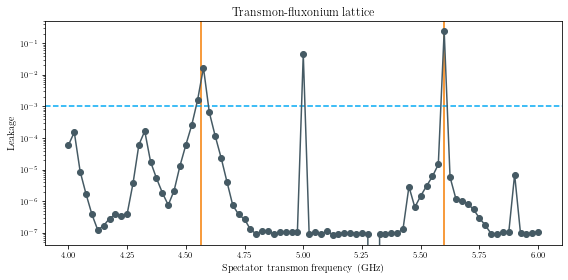

In [43]:
SAVE_IMAGE = False
LOAD_DATA = False

min_leakage_rate = 1e-3
col_8 =  target_transmon.freq - TRANSMON_ANHARM
col_9 = fluxonium_freqs["freq_04"] - target_transmon.freq

col_x = target_transmon.freq + TRANSMON_ANHARM

if LOAD_DATA:
    lattice_type = "mixed"
    da_name = f"{lattice_type}_spec_collision_scan.nc"
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=500, figsize=(8,4))
    
    ax.axvline(
        col_8, 
        linestyle = "-", 
        color="#f57c00"
    )
    
    ax.axvline(
        col_9, 
        linestyle = "-", 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.plot(leakage_rates.spectator_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Spectator transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        image_name = f"{lattice_type}_spec_collision_scan"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()

In [57]:
SAVE_DATA = False
FREQ_RANGE = 0.02 #GHz
NUM_POINTS = 21

collision_cond = target_transmon.freq + TRANSMON_ANHARM
spectator_freqs = np.linspace(collision_cond - FREQ_RANGE, collision_cond + FREQ_RANGE, NUM_POINTS)

results = []
comp_labels = comp_state_labels(3)

for spec_freq in spectator_freqs:
    spec_transmon = qubits.SimpleTransmon(
        label = 'spectator', 
        max_freq = spec_freq, 
        anharm = TRANSMON_ANHARM,
        diel_loss_tan = DIEL_LOSS_TANGENT,
        env_thermal_energy = THERMAL_ENERGY,    
        dim_hilbert = TRANSMON_LEVELS
    )
    
    control_spectator_coup = couplers.capacitive_coupling(
        qubits=[control_fluxonium, spec_transmon],
        strength=coup_strength,
    )
    
    full_sys = systems.QubitSystem(
        qubits=[target_transmon, control_fluxonium, spec_transmon],
        coupling=[target_control_coup, control_spectator_coup]
    )
    
    full_sys['control'].drives['cr_drive'].set_params(**drive_params)
    
    comp_states = get_states(full_sys, comp_labels)
    comp_states_list = list(comp_states.values())
    
    leakage_rate = get_leakage(
        times = times,
        system = full_sys,
        comp_states = comp_states_list,
        options = SOLVER_OPTIONS,
        with_noise = False
    )
    
    results.append(leakage_rate)
    
leakage_rates = xr.DataArray(
    results,
    dims = ["spectator_freq"],
    coords = dict(spectator_freq = spectator_freqs),
    attrs = dict(
        fluxonium_charge_energy = control_fluxonium.charge_energy,
        fluxonium_induct_energy = control_fluxonium.induct_energy,
        fluxonium_joseph_energy = control_fluxonium.joseph_energy,
        target_freq = target_transmon.freq,
        anharm = TRANSMON_ANHARM,
        collision_cond = collision_cond,
        rise_time = RISE_TIME,
        eps_drive = EPS_DRIVE,
        pulse_time = drive_params["pulse_time"],
        drive_freq = drive_params["freq"],
        points_per_drive_period = 10,
        transmon_levels = TRANSMON_LEVELS,
        fluxonium_levels = FLUXONIUM_LEVELS,
    )
)

if SAVE_DATA:
    lattice_type = "mixed"
    collision_type = "spectator"
    n_photons = 1
    trans = "spec_12"
    da_name = f"{lattice_type}_spec_collision_scan_detailed.nc"
    leakage_rates.to_netcdf(DATA_FOLDER / da_name)

<ipython-input-59-a6abb327f08f>:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


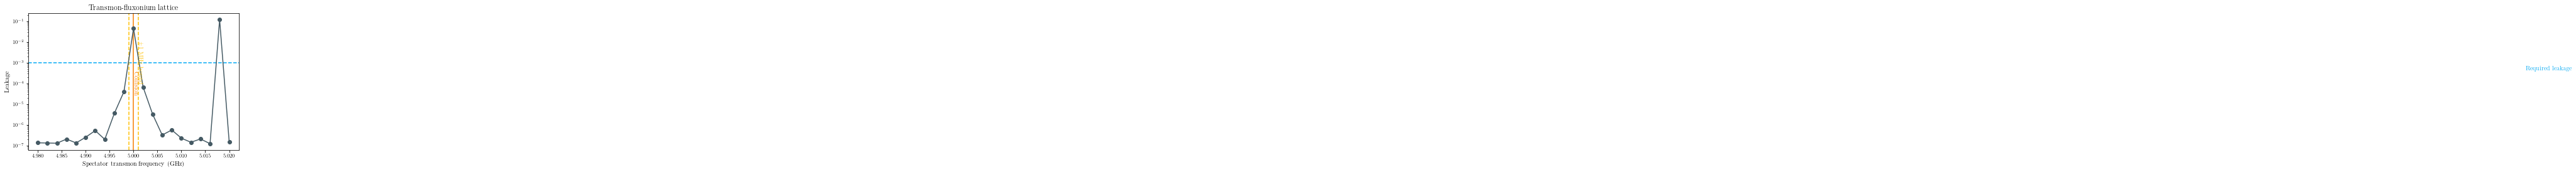

In [59]:
SAVE_IMAGE = False
LOAD_DATA = False

freq_range = 0.001
min_leakage_rate = 1e-3

if LOAD_DATA:
    lattice_type = "mixed"
    da_name = f"{lattice_type}_spec_collision_scan_detailed.nc"
    
    leakage_rates = xr.load_dataarray(DATA_FOLDER / da_name)
     
with plt.rc_context(TEX_RC_PARAMS):
    fig, ax = plt.subplots(dpi=200)

    ax.axvline(
        leakage_rates.collision_cond, 
        linestyle = "-", 
        color="#f57c00"
    )
    ax.text(
        leakage_rates.collision_cond, 
        1e-4, 
        "Collision", 
        horizontalalignment="left", 
        verticalalignment="center", 
        rotation=-90, 
        color="#f57c00"
    )

    ax.axhline(min_leakage_rate, linestyle = "--", color="#03a9f4")
    ax.text(
        5.5, 
        min_leakage_rate - 5e-4, 
        "Required leakage", 
        ha="left",  va="center", 
        color="#03a9f4"
    )

    ax.axvline(leakage_rates.collision_cond - freq_range, linestyle = "--", color="#ffc107")
    ax.axvline(leakage_rates.collision_cond + freq_range, linestyle = "--", color="#ffc107")
    ax.text(
        leakage_rates.collision_cond + freq_range, 
        1e-3, 
        f"$\pm${int(freq_range*1e3)} MHz bound", 
        ha="left", va="center", 
        rotation=-90, 
        color="#ffc107"
    )

    ax.plot(leakage_rates.spectator_freq, leakage_rates, linestyle="-", marker="o", color="#455a64")

    ax.set_yscale("log")
    ax.set_ylabel("Leakage")
    ax.set_xlabel("Spectator transmon frequency (GHz)")
    ax.set_title("Transmon-fluxonium lattice")

    plt.tight_layout()

    if SAVE_IMAGE:
        lattice_type = "mixed"
        collision_type = "spectator"
        n_photons = 1
        trans = "spec_12"
        image_name = f"{lattice_type}_spec_col_scan_detailed"
        for file_format in ['pdf', 'png']:
            full_name = f"{image_name}.{file_format}"
            plt.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format
            )
    plt.show()